<h1>The heterogeneity and robustness of the Kuznets curve

https://docs.google.com/document/d/1M99QQbTWXdMceAiBRSqCsgX0dTrR9O3X50fAD2F2QrA/edit

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import skew, kurtosis
import arch.unitroot as ur
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima import auto_arima


In [145]:
df = pd.read_csv('canada.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('[^\\w\\s]','')
df = df.rename(columns={'time' : 'year', 'gdp_per_capita_(current_us$)_[ny.gdp.pcap.cd]' : 'gdp', 'co2_emissions_(metric_tons_per_capita)_[en.atm.co2e.pc]' : 'co2', 'gini_index_[si.pov.gini]' : 'gini'})
df = df.replace('..', np.nan).dropna()

cols = ['gdp', 'co2', 'gini']
for col in cols:
    df[col] = pd.to_numeric(df[col])

data_skewness = skew(df)
data_kurtosis = kurtosis(df)

print(f"Skewness: {data_skewness}")
print(f"Kurtosis: {data_kurtosis}")

for col in cols:
    df[col] = np.log(df[col])

df.describe()

Skewness: [ 0.          0.12082244  0.28754523 -0.72091652]
Kurtosis: [-1.20266963 -1.66482441 -0.78626082 -0.87640102]


,year,gdp,co2,gini
count,30.000000,30.000000,30.000000,30.000000
mean,2004.500000,10.381585,2.765871,3.496157
std,8.803408,0.373290,0.045451,0.027032
min,1990.000000,9.903369,2.688752,3.443618
25%,1997.250000,9.992435,2.737120,3.482774
50%,2004.500000,10.439907,2.761127,3.504054
75%,2011.750000,10.737696,2.803490,3.516755
max,2019.000000,10.871784,2.855356,3.529297


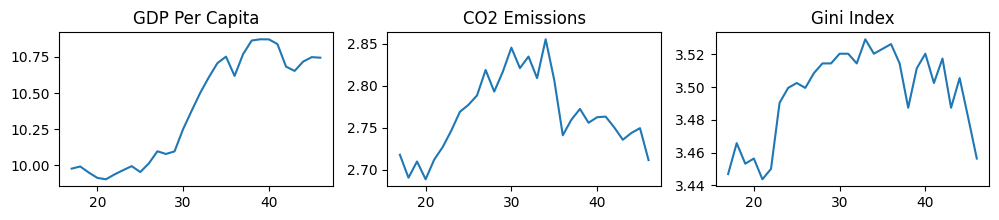

In [146]:
fig, ax = plt.subplots(1, 3, figsize = (12,2))
ax[0].plot(df['gdp'])
ax[0].set_title("GDP Per Capita")
ax[1].plot(df['co2'])
ax[1].set_title("CO2 Emissions")
ax[2].plot(df['gini'])
ax[2].set_title("Gini Index")
plt.show()

<h1>Kuznets Curve

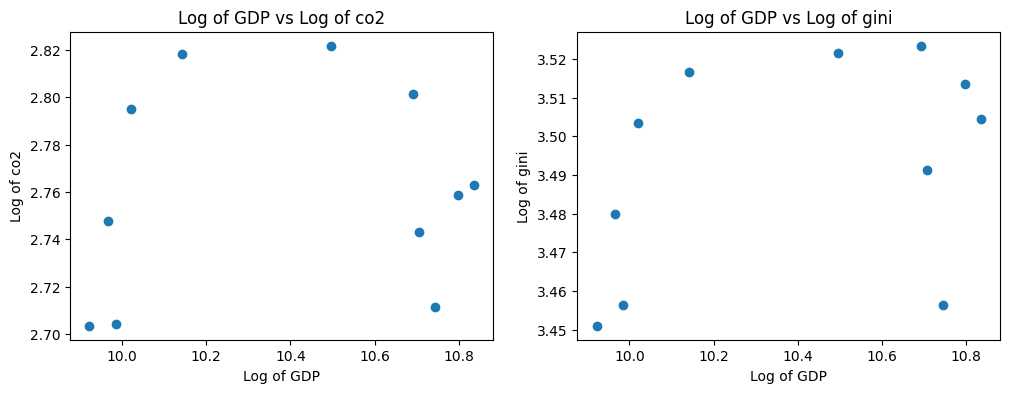

In [147]:
df['year_group'] = df['year'] // 3 * 3
avr_df = df.groupby('year_group')[['gdp','co2', 'gini']].mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize = (12,4))

ax[0].scatter(avr_df['gdp'], avr_df[cols[1]])
ax[0].set_xlabel('Log of GDP')
ax[0].set_ylabel(f'Log of {cols[1]}')
ax[0].set_title(f'Log of GDP vs Log of {cols[1]}')

ax[1].scatter(avr_df['gdp'], avr_df[cols[2]])
ax[1].set_xlabel('Log of GDP')
ax[1].set_ylabel(f'Log of {cols[2]}')
ax[1].set_title(f'Log of GDP vs Log of {cols[2]}')

plt.show()

<h1>Stationary Test

In [148]:
for col in cols:
    series = df[col].values
    adf_y = ur.ADF(series)
    print(f'\n///////////////////{col}///////////////////////')
    print(adf_y.summary())


///////////////////gdp///////////////////////
   Augmented Dickey-Fuller Results   
Test Statistic                 -0.637
P-value                         0.862
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.68 (1%), -2.97 (5%), -2.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

///////////////////co2///////////////////////
   Augmented Dickey-Fuller Results   
Test Statistic                 -1.526
P-value                         0.521
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.68 (1%), -2.97 (5%), -2.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

///////////////////gini///////////////////////
   Augmented Dickey-Fuller Results   
Test Statistic                 -1.916
P-value                         0.325
Lags  

c:\Users\frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]
c:\Users\frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]
c:\Users\frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (

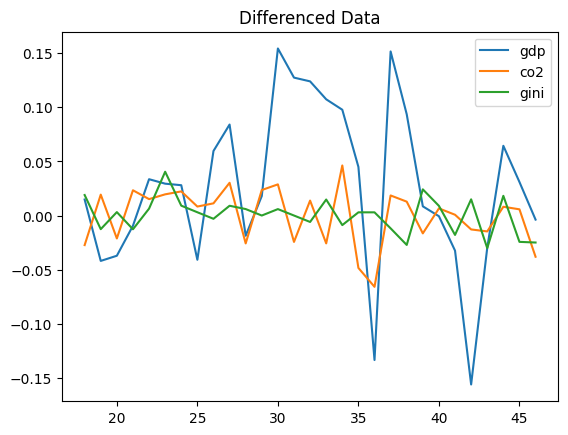

In [149]:
df_diff = df[cols].diff()
df_diff.plot()
plt.title('Differenced Data')
plt.show()

<h1>Differenced Data

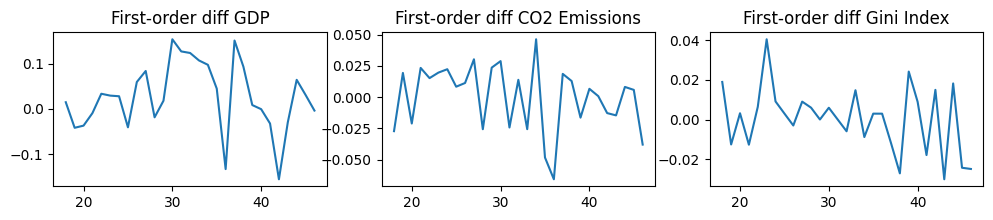

In [150]:
# Perform first-order differencing
df_diff_gdp = df["gdp"].diff(periods=1).dropna()
df_diff_co2 = df["co2"].diff(periods=1).dropna()
df_diff_gini = df["gini"].diff(periods=1).dropna()

fig, ax = plt.subplots(1, 3, figsize = (12,2))
ax[0].plot(df_diff_gdp)
ax[0].set_title("First-order diff GDP")
ax[1].plot(df_diff_co2)
ax[1].set_title("First-order diff CO2 Emissions")
ax[2].plot(df_diff_gini)
ax[2].set_title("First-order diff Gini Index")
plt.show()

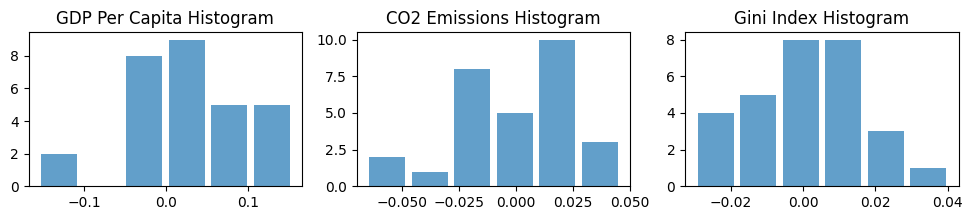

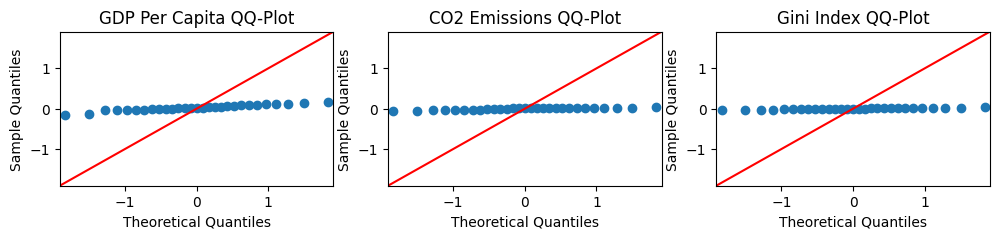

In [151]:
gdp = df_diff_gdp
co2 = df_diff_co2
gini = df_diff_gini

fig, ax = plt.subplots(1, 3, figsize = (12,2))
ax[0].hist(gdp, bins='auto', alpha=0.7, rwidth=0.85)
ax[0].set_title("GDP Per Capita Histogram")
ax[1].hist(co2, bins='auto', alpha=0.7, rwidth=0.85)
ax[1].set_title("CO2 Emissions Histogram")
ax[2].hist(gini, bins='auto', alpha=0.7, rwidth=0.85)
ax[2].set_title("Gini Index Histogram")
plt.show()

fig, ax = plt.subplots(1, 3, figsize = (12,2))
sm.qqplot(gdp, line='45', ax=ax[0])
ax[0].set_title("GDP Per Capita QQ-Plot")
sm.qqplot(co2, line='45', ax=ax[1])
ax[1].set_title("CO2 Emissions QQ-Plot")
sm.qqplot(gini, line='45', ax=ax[2])
ax[2].set_title("Gini Index QQ-Plot")
plt.show()

In [152]:
cols_diff = [gdp, co2, gini]
i = 0
for col in cols_diff:
    print(f'\n//////////////////////{cols[i]}////////////////////')
    shapiro_test = stats.shapiro(col)
    print(f"Shapiro test statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")
    ks_test = stats.kstest(col, 'norm')
    print(f"KS test statistic: {ks_test.statistic}, p-value: {ks_test.pvalue}")
    i += 1


//////////////////////gdp////////////////////
Shapiro test statistic: 0.9644352197647095, p-value: 0.42038458585739136
KS test statistic: 0.4387096892166761, p-value: 1.3439670863592312e-05

//////////////////////co2////////////////////
Shapiro test statistic: 0.9461186528205872, p-value: 0.14500802755355835
KS test statistic: 0.48155865313402935, p-value: 1.0385820023856552e-06

//////////////////////gini////////////////////
Shapiro test statistic: 0.9740309715270996, p-value: 0.6728940010070801
KS test statistic: 0.4879845747725019, p-value: 6.89415559562306e-07


<h1>ACF and PACF

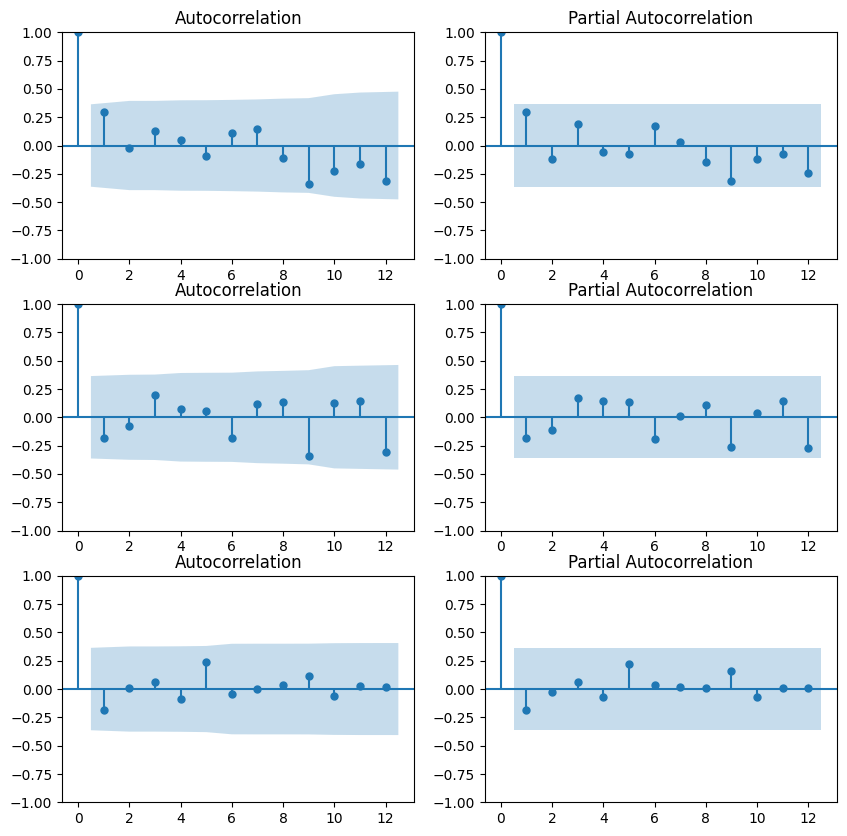

In [153]:
fig, ax = plt.subplots(3, 2, figsize = (10,10))
sm.graphics.tsa.plot_acf(gdp, lags=12, ax=ax[0, 0])
sm.graphics.tsa.plot_pacf(gdp, lags=12, ax=ax[0, 1])
sm.graphics.tsa.plot_acf(co2, lags=12, ax=ax[1, 0])
sm.graphics.tsa.plot_pacf(co2, lags=12, ax=ax[1, 1])
sm.graphics.tsa.plot_acf(gini, lags=12, ax=ax[2, 0])
sm.graphics.tsa.plot_pacf(gini, lags=12, ax=ax[2, 1])
plt.show()

<h1>Auto ARIMA, Forecasts, LJ Test, MSE, MAE, MAPE

c:\Users\frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (11) is shorter than m (12). Using D=1
  warnings.warn("Appropriate D value may not have been reached; "


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-6.737, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-14.392, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-10.496, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-10.509, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-13.167, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-12.392, Time=0.05 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-12.392, Time=0.07 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=-10.392, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-12.496, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-12.509, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-10.662, Time=0.25 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.331 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:              

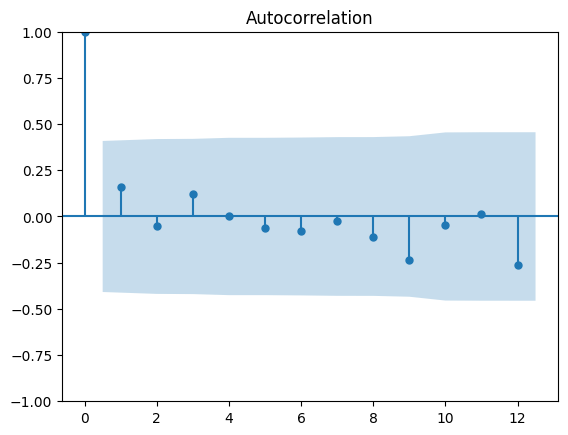

     lb_stat  lb_pvalue
12  7.877712   0.794612


//////////////////////////////////////////////////////////
Forecasts:
 23    0.079242
24    0.215459
25    0.188555
26    0.185090
27    0.168531
28    0.158891
dtype: float64
Actual values:
 41   -0.032422
42   -0.155994
43   -0.029813
44    0.064379
45    0.030963
46   -0.003756
Name: gdp, dtype: float64


//////////////////////////////////////////////////////////
RMSE: 0.207
MAE: 0.187
MAPE: 10.463


c:\Users\frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [154]:
train, test = train_test_split(gdp, test_size=0.2, shuffle=False)
# Find the optimal ARIMA model for the train set
model = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, m=12, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
print(model.summary())

print('\n\n//////////////////////////////////////////////////////////')
# Check the residuals
residuals = model.resid()
sm.graphics.tsa.plot_acf(residuals, lags=12)  # adjust the number of lags here
plt.show()
lj = sm.stats.acorr_ljungbox(residuals, lags=[12], return_df=True)
print(lj)

print('\n\n//////////////////////////////////////////////////////////')
start = test.index[0]
end = test.index[-1]
forecasts = model.predict(n_periods=len(test), start=start, end=end)
print('Forecasts:\n', forecasts)
print('Actual values:\n', test)

print('\n\n//////////////////////////////////////////////////////////')
# Calculate the error metrics
rmse = np.sqrt(mean_squared_error(test, forecasts))
mae = mean_absolute_error(test, forecasts)
mape = mean_absolute_percentage_error(test, forecasts)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)

<h1>OLS

In [155]:
df['gdp_squared'] = df['gdp']**2
formula = 'gini ~ gdp + gdp_squared'
model = smf.ols(formula, data=df)
ols = model.fit()

print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:                   gini   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     12.20
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           0.000168
Time:                        14:51:09   Log-Likelihood:                 75.917
No. Observations:                  30   AIC:                            -145.8
Df Residuals:                      27   BIC:                            -141.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -17.4650      5.861     -2.980      

In [156]:
df['gdp_squared'] = df['gdp']**2
formula = 'co2 ~ gdp + gdp_squared'
model = smf.ols(formula, data=df)
ols = model.fit()

print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     7.984
Date:                Wed, 03 Jan 2024   Prob (F-statistic):            0.00189
Time:                        14:51:13   Log-Likelihood:                 57.644
No. Observations:                  30   AIC:                            -109.3
Df Residuals:                      27   BIC:                            -105.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -38.0515     10.778     -3.531      